# 房價預測
本文件為機器學習課程的學習筆記，將利用常見的 Machine Learning 框架 Random Forest 和 XGBoost 來進行房價預測，並比較不同框架的優劣，分析過程共分為以下幾個部分：
* 資料清洗 Data Cleaning
* 特徵轉換 Feature Engineering
* 區分 Train 訓練集 與 Test 測試集
* 模型調整 Model Tuning
  * 利用 Random Forest 預測房價， 以 Successive Halving algorithm 調整參數
  * 利用 XGBoost 預測房價， 以迴圈選擇適合參數
  * 再以 Successive Halving algorithm 調整 XGBoost 參數
* 模型評估 Model Evaluation


In [1]:
import pandas as pd
import numpy as np

from scipy.stats import norm

from sklearn.experimental import enable_halving_search_cv

from sklearn.model_selection import train_test_split
from sklearn.model_selection import HalvingRandomSearchCV as HRSCV
from sklearn.ensemble import RandomForestRegressor

from project_module import data_cleaning
from project_module import feature_engineering
from project_module import regression_report

from sklearn.metrics import mean_squared_error

##### Data Cleaning
- 引用模組 將缺失值過多的欄位刪去
- 以眾數填補缺失值
- 部分資料以 KNNImputer 填補缺失值(資料中距離最近的幾個點的值之平均)

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
total = data_cleaning(train, test)
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 364
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallCo

##### Feature Engineering
- 引用模組 進行特徵轉換 使資料容易套用模型，主要方法有：
    - Label Encoding
    - 部分類別資料以 One-hot Encoding 編碼

In [3]:
total_fe = feature_engineering(total)
total_fe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 364
Data columns (total 90 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MSSubClass         1460 non-null   int64  
 1   MSZoning           1460 non-null   int64  
 2   LotFrontage        1460 non-null   float64
 3   LotArea            1460 non-null   int64  
 4   Street             1460 non-null   int32  
 5   Neighborhood       1460 non-null   int32  
 6   Condition1         1460 non-null   int32  
 7   Condition2         1460 non-null   int64  
 8   HouseStyle         1460 non-null   int32  
 9   OverallQual        1460 non-null   int64  
 10  OverallCond        1460 non-null   int64  
 11  RoofStyle          1460 non-null   int64  
 12  RoofMatl           1460 non-null   int32  
 13  Exterior1st        1460 non-null   int32  
 14  Exterior2nd        1460 non-null   int32  
 15  MasVnrType         1460 non-null   int64  
 16  MasVnrArea         1460 n

#### Train test split

In [4]:
target = 'SalePrice'
train_size = train.shape[0]
Y = total_fe[target]
X = total_fe.drop(columns = [target])

In [5]:
# training data
x_train = np.array(X[: train_size])
y_train = np.array(Y[:train_size])

# testing data
x_test = np.array(X[train_size: ])
y_test = np.array(Y[train_size: ])

print(f'Training: {x_train.shape, y_train.shape}')
print(f'Testing: {x_test.shape, y_test.shape}')

Training: ((1095, 89), (1095,))
Testing: ((365, 89), (365,))


##### Model Tuning

##### Random Forest Regressor
- 建立Random Forest Regressor模型並進行預測：  
    Random Forest 為常見的 Machine Learning 學習框架之一，基本概念為將資料做 Bagging ，結合多個決策樹做整體學習。  
- 再利用 Successive Halving Algorithm 選擇模型參數：  
    可以看作是一種更有效率的方式，將隨機選出的參數組合作評比，每次評比淘汰部分的模型，使調整參數更有效率。

In [ ]:
from sklearn.ensemble import RandomForestRegressor
RF = RandomForestRegressor()

search_params = {
    'n_estimators': np.arange(100, 500),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 11),
    'max_depth': np.arange(1, 5)
}

SH_search = HRSCV(
    estimator = RF, param_distributions = search_params, n_candidates = 'exhaust', 
    factor = 2, resource = 'n_samples'
)

SH_search.fit(x_train, y_train)

print(f'Best score is {(-1) * SH_search.best_score_:.4f}')
print(f'Best params is {SH_search.best_params_}')

Best score is -0.7693
Best params is {'n_estimators': 481, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 4}


In [ ]:
best_param = SH_search.best_params_.copy()

RF_HRS = RandomForestRegressor(**best_param)
RF_HRS.fit(x_train, y_train)
pred = RF_HRS.predict(x_test)
regression_report(y_test, pred, True)

mse = 1246995559.8388
mae = 20502.6682
rmse = 35312.8243
mape = 0.1221


##### XGBoost
XGBoost 則是以 Boosting 的方式訓練決策樹，在每次訓練都調整前一次預測不好的部分，本次先以迴圈測試不同參數的XGBoost模型表現，並選擇適當的模型參數。

In [25]:
n_estimators = [100, 200, 300, 400, 500]
learning_rate = [0.2, 0.3, 0.4, 0.5]
max_depth = [2, 5]
from xgboost import XGBRegressor

score_table = pd.DataFrame(columns = ('n_estimators', 'learning_rate', 'max_depth', 'score_train', 'score_test'))

for i in n_estimators:
    for j in learning_rate:
        for k in max_depth:
            XGBmodel = XGBRegressor(n_estimators = i, learning_rate = j, max_depth = k)
            XGBmodel.fit(x_train, y_train)
            score_train = XGBmodel.score(x_train, y_train)
            score_test = XGBmodel.score(x_test, y_test)
            score_t = pd.DataFrame([[i, j, k, round(score_train, 4), round(score_test, 4)]], \
                columns = ('n_estimators', 'learning_rate', 'max_depth', 'score_train', 'score_test'))
            score_table = pd.concat([score_table, score_t], axis = 0)
score_table_sklearn = score_table.reset_index(drop=True)

In [26]:
score_table_sklearn.sort_values(by = ['score_test', 'score_train'])


,n_estimators,learning_rate,max_depth,score_train,score_test
15,200,0.5,5,1.0000,0.7670
23,300,0.5,5,1.0000,0.7670
31,400,0.5,5,1.0000,0.7670
39,500,0.5,5,1.0000,0.7670
7,100,0.5,5,0.9999,0.7672
13,200,0.4,5,1.0000,0.7759
21,300,0.4,5,1.0000,0.7759
29,400,0.4,5,1.0000,0.7759
37,500,0.4,5,1.0000,0.7759
5,100,0.4,5,0.9996,0.7764


由以上結果可以明顯觀察到，max_depth選擇2為最合適，learning_rate不應該太高。

In [35]:
XGBmodel_for = XGBRegressor(n_estimators = 500, learning_rate = 0.2, max_depth = 2)
XGBmodel_for.fit(x_train, y_train)
p = XGBmodel_for.predict(x_test)
regression_report(y_test, p, True)

mse = 864540635.2353
mae = 15384.7159
rmse = 29403.0719
mape = 0.0881


以訓練結果最好的參數進行訓練，結果如上，可以明顯觀察到誤差的下降。  
接著同樣利用 Successive Halving algorithm 選擇參數。

In [33]:
# 由上述觀察結果，max_depth選擇2為最合適，learning_rate不應該太高。因此參數範圍應設定如下：
search_params = {
    'n_estimators': np.arange(100, 500),
    'learning_rate' : np.arange(0.1, 0.5, step = 0.01),
    'max_depth': np.arange(1, 5)
}

SH_search = HRSCV(
    estimator = XGBmodel, param_distributions = search_params, n_candidates = 'exhaust', 
    factor = 2, resource = 'n_samples'
)

SH_search.fit(x_train, y_train)

print(f'Best score is {(-1) * SH_search.best_score_:.4f}')
print(f'Best params is {SH_search.best_params_}')

Best score is -0.7755
Best params is {'n_estimators': 371, 'max_depth': 2, 'learning_rate': 0.29999999999999993}


In [36]:
best_param = SH_search.best_params_.copy()

XGBmodel_HRS = XGBRegressor(**best_param)
XGBmodel_HRS.fit(x_train, y_train)
pred = XGBmodel_HRS.predict(x_test)
regression_report(y_test, pred, True)

mse = 903682777.7169
mae = 15972.1198
rmse = 30061.3170
mape = 0.0886


雖然訓練結果誤差沒有變少，但利用 Successive Halving algorithm 可以有效節省調整參數的時間。

##### model evaluation
下圖分別為利用 Successive Halving Algorithm 調整參數的模型及以迴圈選擇參數的模型之 Feature importance。

Successive Halving Algorithm：

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

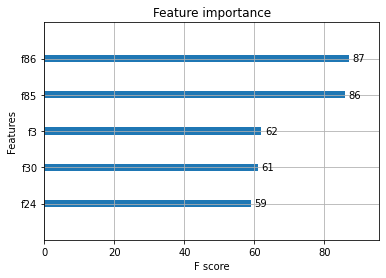

In [37]:
from xgboost import plot_importance
from xgboost import plot_tree
from matplotlib import pyplot as plt
plot_importance(XGBmodel_HRS, max_num_features=5)

迴圈選擇：

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

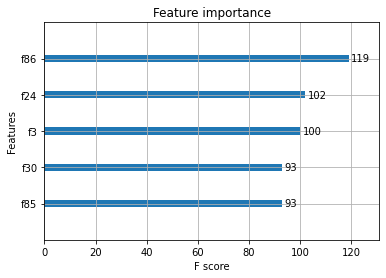

In [38]:
from xgboost import plot_importance
from xgboost import plot_tree
from matplotlib import pyplot as plt
plot_importance(XGBmodel_for, max_num_features=5)

兩者雖然有些微不同，但可以從Feature importance看出主要的特徵皆相同為以下五個欄位：

In [45]:
print(X.columns[[86, 24, 3, 30, 85]])

Index(['Total_sqr_footage', 'BsmtUnfSF', 'LotArea', 'GrLivArea', 'TotalSF'], dtype='object')
